In [1]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import statsmodels.tsa.seasonal as smt
import numpy as np 
import pandas as pd 
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import plotly
import tensorflow as tf
from math import sqrt
print(tf.__version__)

2.3.1


In [2]:
def making_scaled_training_val_test_data(df,train_start_num,val_start_num,test_start_num,test_end_num):
    train_start = train_start_num
    train_end = val_start_num
    train_data = df.loc[train_start:train_end-1]

    val_start = val_start_num
    val_end = test_start_num
    val_data = df.loc[val_start:val_end-1]

    test_start = test_start_num
    test_end = test_end_num
    test_data = df.loc[test_start:test_end-1]

    sc = MinMaxScaler()
    train_sc = sc.fit_transform(train_data)
    val_sc = sc.transform(val_data)
    test_sc = sc.transform(test_data) 
    return train_sc,val_sc,test_sc

def making_train_val(train_data,val_data,windows_size):
    X_train = []
    y_train = []
    X_val = []
    y_val = []

    for i in range(windows_size,train_data.shape[0]):
        X_train.append(train_data[i-windows_size:i])
        y_train.append(train_data[i][0])
    X_train,y_train = np.array(X_train),np.array(y_train)
  
    for i in range(windows_size,val_data.shape[0]):
        X_val.append(val_data[i-windows_size:i])
        y_val.append(val_data[i][0])
    X_val,y_val = np.array(X_val),np.array(y_val)
   
    return X_train,y_train,X_val,y_val

def making_test(test_data,windows_size):
    X_test = []
    y_test = []
    for i in range(windows_size,test_sc.shape[0]):
        X_test.append(test_data[i-windows_size:i])
        y_test.append(test_data[i][0])
    X_test,y_test = np.array(X_test),np.array(y_test) 
    return X_test,y_test

#Evaluation
def MAPE(y_true,y_pred):
    together=0
    leng=len(y_true)
    for i in range(leng):
        together+=np.abs(y_true[i]-y_pred[i])/y_true[i]
    return together/leng

def making_y_pred(model,X_test):
    y_pred= model.predict(X_test)
    y_pred=y_pred.ravel()
    return y_pred
def Eval(model,X_test,y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    rmse = sqrt(mse)
    r = r2_score(y_test,y_pred)
    mape=MAPE(y_test,y_pred)
    print('MSE:',mse,' RMSE:',rmse, 'R^2 score:',r, 'MAPE:', mape)
    return mse,rmse,r,mape

def testset_plot(y_test,y_pred):
    plt.plot(y_test,c = 'r')
    plt.plot(y_pred,c = 'b')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('stock price')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

# handling_newsheadlines

In [3]:
newsheadlines=pd.read_csv('training_data.csv',encoding='windows-1252')

In [4]:
newsheadlines['Company'].value_counts()

AMZN    68
KSS     65
WMT     64
AAPL    63
TSLA    63
EPC     62
ADS     56
AMD     55
BDN     40
DBX     33
Name: Company, dtype: int64

In [5]:
news_amd=newsheadlines.loc[newsheadlines['Company']=='AMD']

In [6]:
#Change the time and date 
import datetime
for i in range(len(news_amd)):
    news_amd['date'].iloc[i]=datetime.datetime.strptime(news_amd['date'].iloc[i],'%b-%d-%y').strftime('%Y-%m-%d')   
    news_amd['time'].iloc[i]=datetime.datetime.strptime(news_amd['time'].iloc[i],'%I:%M%p').strftime('%H:%M') 

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
#considering time after1700
for i in range(len(news_amd)):
    if datetime.datetime.strptime(news_amd['time'].iloc[i],"%H:%M")> datetime.datetime.strptime('17:00', "%H:%M"):
        date = datetime.datetime.strptime(news_amd['date'].iloc[i], "%Y-%m-%d")
        modified_date = date + datetime.timedelta(days=1)
        news_amd['date'].iloc[i]=datetime.datetime.strftime(modified_date, "%Y-%m-%d")

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
news_amd

,Company,date,time,headline,Sentiment
312,AMD,2020-11-11,15:56,"Apple is taking control, and a risky bet, with...",1
313,AMD,2020-11-11,15:56,"Dow Jones Rallies 150 Points, As Tech Stocks S...",0
314,AMD,2020-11-11,15:56,"Model N (MODN) Q4 Earnings Beat, Stock Down on...",0
315,AMD,2020-11-11,15:56,2 Growth Stocks I'd Buy Right Now,1
316,AMD,2020-11-11,15:56,IBM and AMD Begin Cooperation on Cybersecurity...,1
317,AMD,2020-11-11,15:56,"Dow Jones Futures Rise 200 Points, While Tech ...",1
318,AMD,2020-11-11,15:56,"IBM and AMD will work together on security, ar...",1
319,AMD,2020-11-11,15:56,IBM and AMD Announce Joint Development Agreeme...,1
320,AMD,2020-11-10,14:47,"Apple announces its first-ever M1 processor, c...",1
321,AMD,2020-11-10,14:47,"Why Shares of Zoom, Pinterest, and Advanced Mi...",0


In [9]:
df_AMD=pd.read_csv("AMD_indicators.csv")

In [10]:
df_AMD2=df_AMD.copy()

In [11]:
df_AMD2['sentiment']=0
df_AMD2['sentiment2']=0

In [12]:
#counting sentiment in each day
for i in range(len(news_amd)):
    for j in range(len(df_AMD2)):
        if news_amd['date'].iloc[i]==df_AMD2['Date'].iloc[j]:
            df_AMD2['sentiment2'].iloc[j]+=1
            if news_amd['Sentiment'].iloc[i]==1:
                df_AMD2['sentiment'].iloc[j]+=1

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
#sentiment score
df_AMD2['sentiment_score']=df_AMD2['sentiment']/df_AMD2['sentiment2']

In [14]:
df_AMD2.drop(['sentiment','sentiment2'], axis=1,inplace=True)

In [15]:
df_AMD2['sentiment_score']=df_AMD2['sentiment_score'].fillna(0)

In [16]:
df_AMD2

,Date,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI,10 DAYS EMA,20 DAYS EMA,MACD,sentiment_score
0,1980-03-17,0.000000,3.302083,3.125000,3.145833,3.145833,219600,0.177083,3.145833,0.000000,0.000000,0.000000,0.000000,NaN,3.145833,3.145833,0.000000,0.000000
1,1980-03-18,0.000000,3.125000,2.937500,3.031250,3.031250,727200,0.187500,3.031250,0.000000,0.000000,0.000000,0.000000,NaN,3.125000,3.134921,-0.009141,0.000000
2,1980-03-19,0.000000,3.083333,3.020833,3.041667,3.041667,295200,0.062500,3.041667,0.000000,0.000000,0.000000,0.000000,NaN,3.109848,3.126039,-0.015367,0.000000
3,1980-03-20,0.000000,3.062500,3.010417,3.010417,3.010417,159600,0.052083,3.010417,0.000000,0.000000,0.000000,0.000000,NaN,3.091770,3.115028,-0.022563,0.000000
4,1980-03-21,0.000000,3.020833,2.906250,2.916667,2.916667,130800,0.114583,2.916667,0.000000,0.000000,0.000000,0.000000,NaN,3.059933,3.096136,-0.035422,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,2020-11-05,83.269997,83.500000,81.849998,83.000000,83.000000,46542300,1.650002,-0.269997,77.317142,79.339999,81.141428,3.412531,46.361410,79.425322,80.022547,-0.681415,1.000000
10250,2020-11-06,83.519997,86.089996,82.669998,85.879997,85.879997,53829900,3.419998,2.360001,77.905714,79.327856,80.965714,3.921513,49.673958,80.598899,80.580399,-0.124774,0.833333
10251,2020-11-09,84.239998,87.050003,82.769997,83.120003,83.120003,58580700,4.280006,-1.119995,79.259999,79.604999,80.935713,4.664679,56.983435,81.057282,80.822266,0.092593,1.000000
10252,2020-11-10,81.930000,82.129997,77.629997,77.989998,77.989998,67006400,4.500000,-3.940002,79.988571,79.716428,80.936666,4.832765,52.591371,80.499594,80.552527,-0.147392,0.500000


## training with sentiment_score

In [17]:
df_AMD_picked = df_AMD2[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume','sentiment_score']] # Picking the features with high correlation
windows_size=20

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)

In [18]:
model_linear_amd = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 7]),
    tf.keras.layers.Dense(1)
])

model_linear_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'mean_squared_error')

history_linear_amd = model_linear_amd.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0407 - val_loss: 0.0167
Epoch 2/100
70/70 [==============================] - 0s 600us/step - loss: 0.0127 - val_loss: 0.0140
Epoch 3/100
70/70 [==============================] - 0s 615us/step - loss: 0.0099 - val_loss: 0.0144
Epoch 4/100
70/70 [==============================] - 0s 600us/step - loss: 0.0080 - val_loss: 0.0133
Epoch 5/100
70/70 [==============================] - 0s 629us/step - loss: 0.0065 - val_loss: 0.0112
Epoch 6/100
70/70 [==============================] - 0s 643us/step - loss: 0.0055 - val_loss: 0.0100
Epoch 7/100
70/70 [==============================] - 0s 643us/step - loss: 0.0047 - val_loss: 0.0085
Epoch 8/100
70/70 [==============================] - 0s 629us/step - loss: 0.0040 - val_loss: 0.0073
Epoch 9/100
70/70 [==============================] - 0s 629us/step - loss: 0.0035 - val_loss: 0.0059
Epoch 10/100
70/70 [==============================] - 0s 615us/step - loss: 0.0031 - val_loss

70/70 [==============================] - 0s 586us/step - loss: 2.7499e-04 - val_loss: 1.2646e-04
Epoch 78/100
70/70 [==============================] - 0s 586us/step - loss: 2.7465e-04 - val_loss: 1.2688e-04
Epoch 79/100
70/70 [==============================] - 0s 601us/step - loss: 3.1305e-04 - val_loss: 2.4645e-04
Epoch 80/100
70/70 [==============================] - 0s 586us/step - loss: 2.8292e-04 - val_loss: 1.3913e-04
Epoch 81/100
70/70 [==============================] - 0s 615us/step - loss: 2.6965e-04 - val_loss: 1.2962e-04
Epoch 82/100
70/70 [==============================] - 0s 600us/step - loss: 2.8222e-04 - val_loss: 1.2323e-04
Epoch 83/100
70/70 [==============================] - 0s 601us/step - loss: 2.7197e-04 - val_loss: 1.2246e-04
Epoch 84/100
70/70 [==============================] - 0s 629us/step - loss: 2.6494e-04 - val_loss: 1.4847e-04
Epoch 85/100
70/70 [==============================] - 0s 586us/step - loss: 2.7637e-04 - val_loss: 2.5579e-04
Epoch 86/100
70/70 [===

Text(0.5, 1.0, 'Training and validation loss')

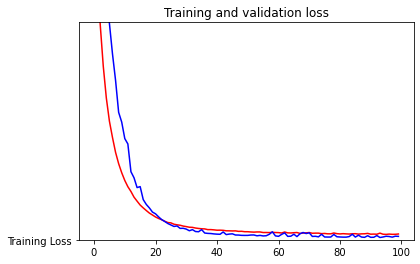

In [19]:
%matplotlib inline
loss_linear_amd=history_linear_amd.history['loss']
val_loss_linear_amd=history_linear_amd.history['val_loss']

epochs=range(len(loss_linear_amd)) 

plt.plot(epochs, loss_linear_amd, 'r', "Training Loss")
plt.plot(epochs, val_loss_linear_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [20]:
X_test_amd,y_test_amd=making_test(test_sc,20)
y_pred_linear_amd=making_y_pred(model_linear_amd,X_test_amd)
mse_linear_amd,rmase_linear_amd,r_linear_amd,mape_linear_amd=Eval(model_linear_amd,X_test_amd,y_test_amd,y_pred_linear_amd)

MSE: 0.000493952878153564  RMSE: 0.022225050689561182 R^2 score: 0.9826757765839185 MAPE: 0.037164521486042656


R^2 score: 0.9826757765839185 MAPE: 0.037164521486042656

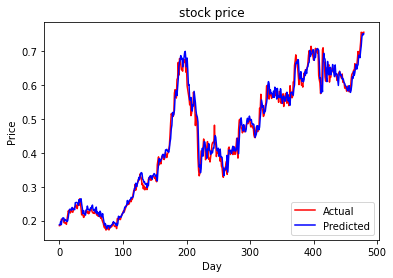

In [21]:
testset_plot(y_test_amd,y_pred_linear_amd)

## training without sentiment score

In [22]:
df_AMD=pd.read_csv("AMD_indicators.csv")
df_AMD_picked = df_AMD2[['Close','H-L','7 DAYS STD DEV','RSI','MACD','Volume']] # Picking the features with high correlation
windows_size=20

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)

In [23]:
model_linear_amd = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 6]),
    tf.keras.layers.Dense(1)
])

model_linear_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'mean_squared_error')

history_linear_amd = model_linear_amd.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 0s 1ms/step - loss: 0.1677 - val_loss: 0.0384
Epoch 2/100
70/70 [==============================] - 0s 586us/step - loss: 0.0238 - val_loss: 0.0286
Epoch 3/100
70/70 [==============================] - 0s 558us/step - loss: 0.0170 - val_loss: 0.0244
Epoch 4/100
70/70 [==============================] - 0s 558us/step - loss: 0.0147 - val_loss: 0.0206
Epoch 5/100
70/70 [==============================] - 0s 558us/step - loss: 0.0130 - val_loss: 0.0195
Epoch 6/100
70/70 [==============================] - 0s 558us/step - loss: 0.0116 - val_loss: 0.0187
Epoch 7/100
70/70 [==============================] - 0s 558us/step - loss: 0.0103 - val_loss: 0.0188
Epoch 8/100
70/70 [==============================] - 0s 601us/step - loss: 0.0094 - val_loss: 0.0182
Epoch 9/100
70/70 [==============================] - 0s 586us/step - loss: 0.0085 - val_loss: 0.0184
Epoch 10/100
70/70 [==============================] - 0s 572us/step - loss: 0.0077 - val_loss

70/70 [==============================] - 0s 629us/step - loss: 4.1785e-04 - val_loss: 2.2344e-04
Epoch 77/100
70/70 [==============================] - 0s 572us/step - loss: 4.0486e-04 - val_loss: 2.1412e-04
Epoch 78/100
70/70 [==============================] - 0s 586us/step - loss: 3.9127e-04 - val_loss: 2.6306e-04
Epoch 79/100
70/70 [==============================] - 0s 572us/step - loss: 3.8281e-04 - val_loss: 2.3304e-04
Epoch 80/100
70/70 [==============================] - 0s 586us/step - loss: 3.8930e-04 - val_loss: 1.8731e-04
Epoch 81/100
70/70 [==============================] - 0s 601us/step - loss: 3.8136e-04 - val_loss: 2.0138e-04
Epoch 82/100
70/70 [==============================] - 0s 601us/step - loss: 3.7378e-04 - val_loss: 1.8405e-04
Epoch 83/100
70/70 [==============================] - 0s 601us/step - loss: 3.9562e-04 - val_loss: 3.9606e-04
Epoch 84/100
70/70 [==============================] - 0s 586us/step - loss: 3.6377e-04 - val_loss: 2.1090e-04
Epoch 85/100
70/70 [===

Text(0.5, 1.0, 'Training and validation loss')

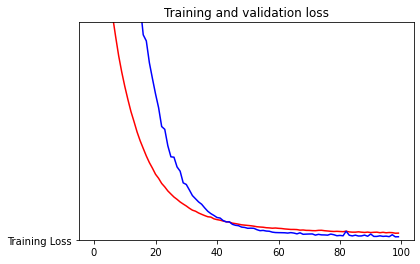

In [24]:
%matplotlib inline
loss_linear_amd=history_linear_amd.history['loss']
val_loss_linear_amd=history_linear_amd.history['val_loss']

epochs=range(len(loss_linear_amd)) 

plt.plot(epochs, loss_linear_amd, 'r', "Training Loss")
plt.plot(epochs, val_loss_linear_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [25]:
X_test_amd,y_test_amd=making_test(test_sc,20)
y_pred_linear_amd=making_y_pred(model_linear_amd,X_test_amd)
mse_linear_amd,rmase_linear_amd,r_linear_amd,mape_linear_amd=Eval(model_linear_amd,X_test_amd,y_test_amd,y_pred_linear_amd)

MSE: 0.0006237313375411869  RMSE: 0.024974613861703385 R^2 score: 0.978124105514746 MAPE: 0.04093555020562544


R^2 score: 0.978124105514746 MAPE: 0.04093555020562544

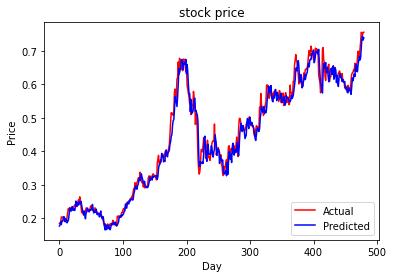

In [26]:
testset_plot(y_test_amd,y_pred_linear_amd)

# One big problem is that our sentiment data cannot go into the training data. Our newsheadlines are mostly after 3rd quarters of 2020, which is for my algo, testset. I also did make small trainingset with sentiment analysis and test again and overall performance is so bad. Thus, we need much more data, like historic data, or figure out some other ways. Thanks!